# Tarea 1

**Juan Antonio Rivera Zavala**

**Fecha de entrega: 30 de Mayo de 2024, 23:59 h.**

## Problema 1 
**Realizar un estudio con el polinomio de interpolación (I), ajuste por secciones (II) y ajuste por mínimos cuadrados (III) de las siguientes funciones:**
**a) $f(x)=2\cos(x)+\sin(2x)+\sqrt{x},$ para $0 \leq x \leq \pi,$ con un espaciamiento regular en el intervalo y un espaciamiento aleatorio (revisar como funciona un generador de números aleatorios) para un número de puntos $n=8,16,32.$**
**b) Realizar la misma exploración que en a) pero ahora con la función:$f(x)=2\cos(\pi x)+\sin(2 \pi x)+\sqrt{\pi x},$ para $0 \leq x \leq 1.$**

**Nota 1: Para el ajuste por mínimos cuadrados pueden usar una base de funciones ortogonales que elijan o una combinación de bases.**

**Nota 2: Es necesaria una comparación gráfica de los resultados, que comenten sobre los errores y lo que observan para cada uno de los tratamientos funcione o no funcione.**

**Nota 3: Comparar entre a) y b) [con espaciamiento regular y aleatorio], así como hacer las observaciones pertinentes de la convergencia, errores, etc.**

In [532]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp


### (I) Polinomio de interpolación

#### Matriz de Vandermonde

Dado un conjunto de $n$ puntos $(x_{0},y_{0}) , \dots , (x_{n-1},y_{n-1})$ con $x_{i}\neq x_{j}$ para todo $i \neq j$, decimos que una función polinomial $p(x)=\sum_{i=0}^{n-1}a_{i} x^{i}$ interpola los datos si $p(x_{i})=y_{i}$ para $i=0,\dots,n-1.$

Veamos que $p(x_{i})=y_{i}$ para $i=0,\dots,n-1$ forma un sistema de $n$ ecuaciones lineales en los coeficientes $\{a_{i}\}$ por lo que podemos escribir el sistema como
\begin{equation}
 X\cdot A = Y
\end{equation}
con $A=(a_0,\dots,a_{n-1})^\top$, $Y=(y_0,\dots,y_{n-1})^\top$ y
\begin{equation}
 X=
 \begin{pmatrix}
  1 & x_{0} & x_{0}^{2} & \cdots & x_{0}^{n-1} \\
  1 & x_{1} & x_{1}^{2} & \cdots & x_{1}^{n-1} \\
  \vdots & \vdots & \vdots & \ddots & \vdots \\
  1 & x_{n-1} & x_{n-1}^{2} & \cdots & x_{n-1}^{n-1}
 \end{pmatrix}
\end{equation}

El polinomio de interpolación $p(x)$ corresponde a la solución $A$ de la ecuación matricial. La matriz $X$ se conoce como la matriz de Vandermonde, la cual es una matriz invertible y, como la ecuación matricial tiene solución única, el polinomio de interpolación $p(x)$ existe y es único.


In [536]:
def matriz_vandermonde(x):
    """
    Genera la matriz de Vandermonde para el arreglo x.
    """
    
    n = len(x)
    v = np.empty((n, n))
    v[:, 0] = 1
    
    for j in range(1, n):
        v[:, j] = v[:, j-1] * x
        
    return v


In [537]:
def polinomio_interpolacion_vandermonde(x, x_puntos, y_puntos):
    """
    Genera un polinomio de interpolación p(x) a partir de la solución de la matriz
    de Vandermonde para (x_puntos, y_puntos).
    """
    
    A = matriz_vandermonde(x_puntos)
    solution = np.linalg.solve(A, y_puntos)
    n = len(x_puntos)
    p = solution[0]
    
    for i in range(1, n):
        p += solution[i]*x**i
        
    return p


#### Polinomio de Lagrange

El polinomio de Lagrange se genera mediante
$$ p(x)=\sum_{i=0}^N y_iL_i(x)\quad, $$
donde
$$ L_i(x)=\prod_{0\leq j\leq N \\ j\neq i}\dfrac{x-x_j}{x_i-x_j}$$
son las bases polinómicas de Lagrange.

In [540]:
def base_lagrange(x, x_puntos, i):
    """
    Calcula la i-ésima base polinómica de Lagrange, L_i
    """
    
    L_i = 1
    n = len(x_puntos)
    
    for j in range(n):
        
        if j != i:
            L_i *= (x - x_puntos[j]) / (x_puntos[i] - x_puntos[j])
            
    return L_i


In [541]:
def polinomio_interpolacion_lagrange(x, x_puntos, y_puntos):
    """
    Genera un polinomio de interpolación p(x) a partir de las bases polinómicas
    de Lagrange para (x_puntos, y_puntos).
    """
    
    p = 0
    n = len(x_puntos)
    
    for i in range(n):
        p += y_puntos[i] * base_lagrange(x, x_puntos, i)
        
    return p


### (II) Ajuste por secciones

Para realizar el ajuste por secciones dividimos el intervalo en $n$ secciones con intervalos definidos entre los puntos $(x_{0},y_{0}),\dots,(x_{n},y_{n})$. En cada sección se usa un polinomio de grado 3 para realizar el ajuste. Entonces, para cada sección tendremos
\begin{equation}
y_i(t)=a_{i} + b_{i} t + c_{i} t^{2} + d_i t^{3}
\end{equation}
con $t=(x - x_{i})/(x_{i+1} - x_{i})$ para $x_{i}\leq x \leq x_{i+1}$ por lo que $0\leq t\leq 1$ para cada $i=0,\dots,n-1.$

Queremos que se cumplan las siguientes condiciones:
\begin{align}
y_{i}(0) & = a_{i} \equiv y_{i} \\
y_{i}(1) & = a_{i} + b_{i} + c_{i} + d_{i} \equiv y_{i+1} \\
y'_{i}(0) & = b_{i} \equiv D_{i} \\
y'_{i}(1) & = b_{i} + 2 c_{i} + 3 d_{i} \equiv D_{i+1}
\end{align}
Alternativamente podemos escribir esto como
\begin{align}
a_{i} & = y_{i} \\
b_{i} & = D_{i} \\
c_{i} & = 3 (y_{i+1} - y_{i}) - 2 D_{i} - D_{i+1} \\
d_{i} & = - 2 (y_{i+1} - y_{i}) + D_{i} + D_{i+1} 
\end{align}

Además, buscaremos que se cumpla la condición de suavidad entre secciones
\begin{equation}
y''_{i-1}(1)=y''_{i}(0)\quad\Rightarrow\quad 2 c_{i-1}+6 d_{i-1} = 2c_{i}
\end{equation}
Esto se puede escribir como
\begin{align}
& 2 [3 (y_{i} - y_{i-1}) - 2 D_{i-1} - D_{i}] + 6 [- 2 (y_{i} - y_{i-1}) + D_{i-1} + D_{i}] = 2[3 (y_{i+1} - y_{i}) - 2 D_{i} - D_{i+1}] \\
\Rightarrow\quad & - 6 y_{i} + 6 y_{i-1} + 2 D_{i-1} + 4 D_{i} = 6 y_{i+1} - 6 y_{i} - 4 D_{i} - 2 D_{i+1} \\
\Rightarrow\quad & 6 y_{i+1} - 6 y_{i-1} = 2 D_{i+1} + 8 D_{i} + 2 D_{i-1} \\
\Rightarrow\quad & 3 (y_{i+1} - y_{i-1}) = D_{i-1} + 4 D_{i} + D_{i+1}
\end{align}

Sin embargo, para los extremos tendremos un comportamiento diferente. Para $y''_0(0) = 0$ por lo que
\begin{align}
& 0 = 2c_{0}\\
\Rightarrow\quad & 3 (y_{1} - y_{0}) = 2 D_{0} + D_{1}
\end{align}
Por otro lado, para $y''_{n-1}(1) = 0$ por lo que
\begin{align}
& 0 = 2 c_{n-1}+6 d_{n-1}\\
\Rightarrow\quad & 2 [3 (y_{n} - y_{n-1}) - 2 D_{n-1} - D_{n}] + 6 [- 2 (y_{n} - y_{n-1}) + D_{n-1} + D_{n}] \\
\Rightarrow\quad & - 6 y_{n} + 6 y_{n-1} + 4 D_{n} + 2 D_{n-1} = 0 \\
\Rightarrow\quad & 3 (y_{n} - y_{n-1}) = D_{n-1} + 2 D_{n}
\end{align}

Entonces tendremos el sistema matricial
\begin{equation}
\underbrace{
\begin{pmatrix}
2 & 1 & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
1 & 4 & 1 & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & 1 & 4 & 1 & 0 & \cdots & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0 & 0 & \cdots & 1 & 4 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & \cdots & 0 & 1 & 4 & 1 \\
0 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 & 1 & 2 \\
\end{pmatrix}
}_{A}
\underbrace{
\begin{pmatrix}
D_{0} \\
D_{1} \\
D_{2} \\
\vdots \\
D_{n-2} \\
D_{n-1} \\
D_{n} \\
\end{pmatrix}
}_{D}
=
\underbrace{
\begin{pmatrix}
3 (y_{1} - y_{0}) \\
3 (y_{2} - y_{0}) \\
3 (y_{3} - y_{1}) \\
\vdots \\
3 (y_{n-1} - y_{n-3}) \\
3 (y_{n} - y_{n-2}) \\
3 (y_{n} - y_{n-1}) \\
\end{pmatrix}
}_{B}
\end{equation}

Por lo tanto, si resolvemos la ecuación matricial para $D$ y sustuimos $(D_{i}, D_{i+1}, y_{i}, y_{i+1})$ en las relaciones de los coeficientes del polinomio de grado 3, encontraremos $(a_{i} ,b_{i}, c_{i}, d_{i})$ para cada sección.

In [544]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve


In [545]:
def B_ajuste_cubico(y_puntos):
    """
    Genera el arreglo B a partir del arreglo y_puntos para el ajuste cúbico 
    por secciones.
    """
    
    Y = 3 * y_puntos
    n = len(y_puntos)
    b = []
    
    for i in range(n):
        
        if i == 0:
            b.append(Y[i+1] - Y[i])
        
        elif i == n-1:
            b.append(Y[i] - Y[i-1])
            
        else:
            b.append(Y[i+1] - Y[i-1])
            
    return b


In [546]:
def coeficientes_ajuste_cubico(y_puntos):
    """
    Calcula los coeficientes para el ajuste cúbico por secciones a partir
    del arreglo y_puntos.
    """    
    
    n = len(y_puntos)
    
    # Definimos las diagonales de la matriz tridiagonal
    diag_arriba_abajo = np.ones(n-1)
    diag_principal = 4 * np.ones(n)
    diag_principal[0] = 2
    diag_principal[-1] = 2
    
    diagonales = [diag_arriba_abajo, diag_principal, diag_arriba_abajo]
    
    # Creamos la matriz tridiagonal dispersa en el formato de columna dispersa compresa
    A = diags(diagonales, offsets=[-1, 0, 1], format='csc')
    
    # Creamos el arreglo de diferencias de paso de los datos y_puntos
    B = B_ajuste_cubico(y_puntos)
    
    # Resolvemos el sistema A*D = B
    D = spsolve(A, B)
    
    # Definimos los coeficientes para cada ajuste
    a = y_puntos[:-1]
    b = D[:-1]
    c = 3*(y_puntos[1:] - y_puntos[:-1]) - 2*D[:-1] - D[1:]
    d = 2*(y_puntos[:-1] - y_puntos[1:]) + D[:-1] + D[1:]
    
    return a, b, c, d


In [547]:
def ajuste_cubico(x, x_puntos, y_puntos):
    """
    Genera un ajuste cúbico con base en los datos (x_puntos, y_puntos) y genera
    la interpolación para el arreglo x.
    """
    
    n = len(x_puntos)
    N = len(x)
    a, b, c, d = coeficientes_ajuste_cubico(y_puntos)
    y = []
    
    for i in range(N):
        
        for j in range(n-1):
            
            if (x[i] >= x_puntos[j]) and (x[i] < x_puntos[j+1]):
                t = (x[i] - x_puntos[j]) / (x_puntos[j+1] - x_puntos[j])
                y_i = a[j] + b[j] * t + c[j] * t**2 + d[j] * t**3
                y.append(y_i)
                
    y_f = a[-1] + b[-1] + c[-1] + d[-1]
    y.append(y_f)
    
    return y


### (III) Ajuste por mínimos cuadrados

Usaremos un modelo para el cual
\begin{equation}
y(x) = \sum_{k=0}^{M-1} a_k X_{k}(x)\quad,
\end{equation}
donde $X_{0}(x),\dots,X_{M-1}(x)$ son funciones fijas arbitrarias de $x$ llamadas funciones base.

Definimos la función de mérito
\begin{equation}
\chi^{2} = \sum_{i=0}^{N-1}\left[\dfrac{y_i - \sum_{k=0}^{M-1} a_k X_{k}(x_i)}{\sigma_i}\right]^2\quad,
\end{equation}
donde $\sigma_{i}$ es el error de medición (desviación estándar) del punto $i$. Si los errores de medición no se conocen, se pueden tomar como $\sigma=1$.

Tomaremos los parámetros que minimicen $\chi^{2}$. Para hacer esto definimos $A$ como la matriz $N \times M$ construida a partir de las $M$ funciones base evaluadas en las $N$ abscisas $x_{i}$

In [550]:
def matriz_de_diseño(x_puntos, f, m):
    """
    Genera una matriz con entradas f(m)(x_puntos) para m funciones.
    """
 
    n = len(x_puntos)
    A = np.array([f(j)(x_puntos[i]) for i in range(n) for j in range(m+1)]).reshape(n, m+1)
        
    return A
    

In [551]:
def minimos_cuadrados(x, x_puntos, y_puntos, f, m):
    """
    Calcula los coeficientes que minimizan el ajuste por mínimos cuadrados
    para m funciones f con datos (x_puntos, y_puntos).
    """
    
    A = matriz_de_diseño(x_puntos, f, m)
    α = np.dot(A.T, A)
    β = np.dot(A.T, y_puntos)
    
    # Resolvemos el sistema α*a = β
    a = np.linalg.solve(α, β)
    f_mat= [f(i)(x) for i in range(m+1)]
    
    return np.dot(a, f_mat)


Decidí usar los polinomios de Hermite como mi base de funciones ortogonales.

In [553]:
def pol_hermite(n):
    """
    Genera el n-ésimo polinomio de Hermite a partir de su relación de
    recurrencia.
    """
    
    if n == 0:
        return lambda x: np.ones_like(x)
        
    elif n == 1:
        return lambda x: 2 * x
        
    else:
        H_n_2 = pol_hermite(n - 2)
        H_n_1 = pol_hermite(n - 1)
        
        # Usamos la relación de recurrencia de los polinomios de Hermite.
        return lambda x: 2 * x * H_n_1(x) - 2 * (n - 1) * H_n_2(x)
        

### Implementación

In [555]:
def espaciamiento_regular(n):
    """
    Genera un arreglo con entradas entre 0 y 1, ordenadas y espaciadas de
    forma regular.
    """
    
    return np.linspace(0, 1, n)


In [556]:
def espaciamiento_aleatorio(n):
    """
    Genera un arreglo con len(n) arreglos y cada uno de estos con n[i] entradas 
    entre 0 y 1, ordenadas y espaciadas de forma aleatoria. Los arreglos se van
    construyendo con base en arreglos más pequeños.
    """
    
    x = []
    a = [0. , 1.]
    
    for i in range(len(n)):
        m = len(a)
        
        while m < n[i]-1:
            aleatorio = np.random.rand()
            
            if aleatorio != 0.:
                a.append(aleatorio)
                m += 1
                
        a_tmp = a.copy()
        x.append(np.sort(a_tmp))
        
    return x


Usaremos:
* `1` para referirnos a la función $f_{1}(x)=2\cos(x)+\sin(2x)+\sqrt{x}$ y
* `2` para referirnos a la función $f_{2}(x)=2\cos(\pi x)+\sin(2 \pi x)+\sqrt{\pi x}.$

In [558]:
def f_1(x):
    
    return 2*np.cos(x) + np.sin(2*x) + np.sqrt(x)


In [559]:
def f_2(x):
    
    return 2*np.cos(np.pi*x) + np.sin(2*np.pi*x) + np.sqrt(np.pi*x)


Ahora escribimos declaramos los datos con los que trabajaremos. Usaremos:
* `r` para referirnos al espaciamiento regular y
* `a` para referirnos al espaciamiento aleatorio.

In [561]:
# Datos

n = [2**i for i in range(3,6)]

N = len(n)

x_r2 = [espaciamiento_regular(n_i) for n_i in n]
x_a2 = espaciamiento_aleatorio(n)

x_r1 = [np.pi*elem for elem in x_r2]
x_a1 = [np.pi*elem for elem in x_a2]

y_r1 = [f_1(elem) for elem in x_r1]
y_a1 = [f_1(elem) for elem in x_a1]

y_r2 = [f_2(elem) for elem in x_r2]
y_a2 = [f_2(elem) for elem in x_a2]


In [562]:
# Espaciamiento regular y aleatorio para f2

x_2 = np.linspace(0, 1, 1000)
y_2 = f_2(x_2)

# (I) Polinomio de interpolación, Vandermonde
pol_r2_v = [polinomio_interpolacion_vandermonde(x_2, x_r2[i], y_r2[i]) for i in range(N)]
pol_a2_v = [polinomio_interpolacion_vandermonde(x_2, x_a2[i], y_a2[i]) for i in range(N)]

# (I) Polinomio de interpolación, Lagrange
pol_r2_l = [polinomio_interpolacion_lagrange(x_2, x_r2[i], y_r2[i]) for i in range(N)]
pol_a2_l = [polinomio_interpolacion_lagrange(x_2, x_a2[i], y_a2[i]) for i in range(N)]

# (II) Ajusto cúbico por secciones
ajuste_cubico_r2 = [ajuste_cubico(x_2, x_r2[i], y_r2[i]) for i in range(N)]
ajuste_cubico_a2 = [ajuste_cubico(x_2, x_a2[i], y_a2[i]) for i in range(N)]

# (III) Mínimos cuadrados
min_cuad_r2 = [minimos_cuadrados(x_2, x_r2[i], y_r2[i], pol_hermite, 7) for i in range(N)]
min_cuad_a2 = [minimos_cuadrados(x_2, x_a2[i], y_a2[i], pol_hermite, 7) for i in range(N)]


In [563]:
# Espaciamiento regular y aleatorio para f1

x_1 = np.pi*x_2
y_1 = f_1(x_1)

# (I) Polinomio de interpolación, Vandermonde
pol_r1_v = [polinomio_interpolacion_vandermonde(x_1, x_r1[i], y_r1[i]) for i in range(N)]
pol_a1_v = [polinomio_interpolacion_vandermonde(x_1, x_a1[i], y_a1[i]) for i in range(N)]

# (I) Polinomio de interpolación, Lagrange
pol_r1_l = [polinomio_interpolacion_lagrange(x_1, x_r1[i], y_r1[i]) for i in range(N)]
pol_a1_l = [polinomio_interpolacion_lagrange(x_1, x_a1[i], y_a1[i]) for i in range(N)]

# (II) Ajusto cúbico por secciones
ajuste_cubico_r1 = [ajuste_cubico(x_1, x_r1[i], y_r1[i]) for i in range(N)]
ajuste_cubico_a1 = [ajuste_cubico(x_1, x_a1[i], y_a1[i]) for i in range(N)]

# (III) Mínimos cuadrados
min_cuad_r1 = [minimos_cuadrados(x_1, x_r1[i], y_r1[i], pol_hermite, 7) for i in range(N)]
min_cuad_a1 = [minimos_cuadrados(x_1, x_a1[i], y_a1[i], pol_hermite, 7) for i in range(N)]


### Figuras

#### (I) Polinomio de interpolación con matriz de Vandermonde

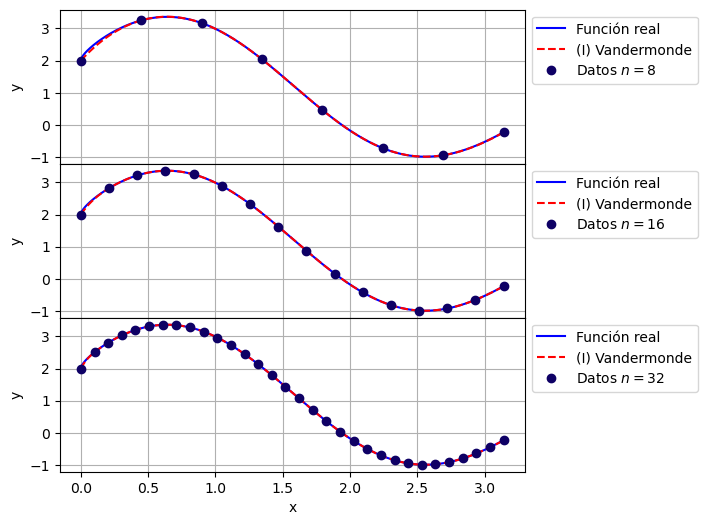

In [566]:
# (I) Polinomio de interpolación con matriz de Vandermonde con espaciamiento regular para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_1, y_1, label='Función real', ls='-', c='b')
    axes[i].plot(x_1, pol_r1_v[i], label='(I) Vandermonde' , ls='--', c='r')
    axes[i].plot(x_r1[i], y_r1[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('Ivrf1.png', bbox_inches='tight')

plt.show()


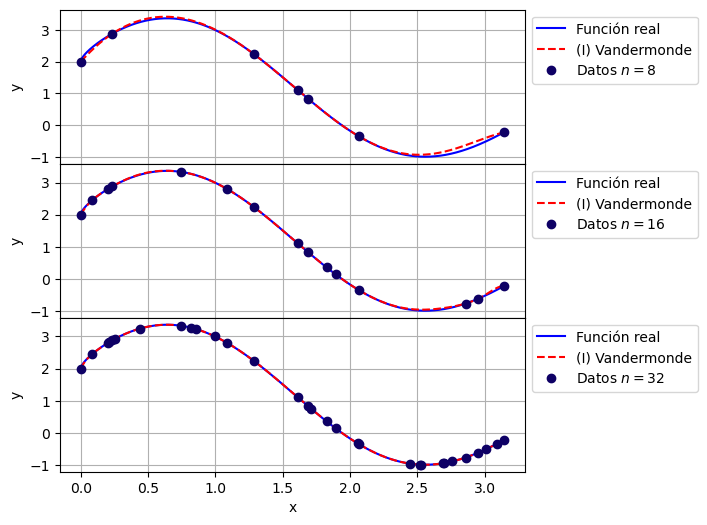

In [567]:
# (I) Polinomio de interpolación con matriz de Vandermonde con espaciamiento aleatorio para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_1, y_1, label='Función real', ls='-', c='b')
    axes[i].plot(x_1, pol_a1_v[i], label='(I) Vandermonde' , ls='--', c='r')
    axes[i].plot(x_a1[i], y_a1[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('Ivaf1.png', bbox_inches='tight')

plt.show()


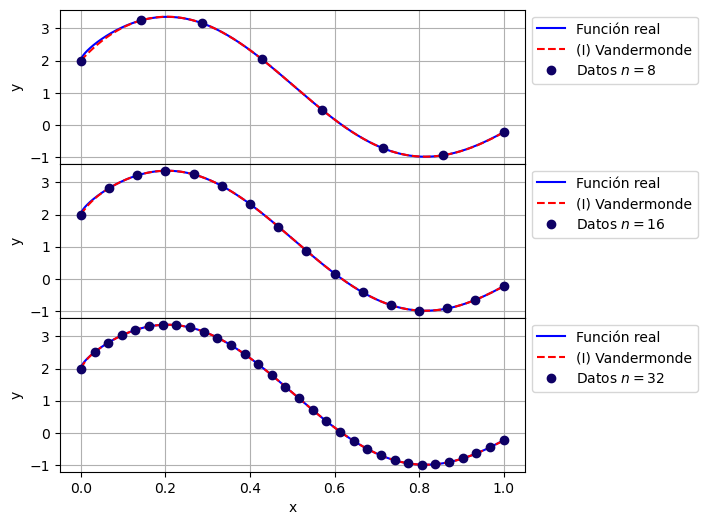

In [568]:
# (I) Polinomio de interpolación con matriz de Vandermonde con espaciamiento regular para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_2, y_2, label='Función real', ls='-', c='b')
    axes[i].plot(x_2, pol_r2_v[i], label='(I) Vandermonde' , ls='--', c='r')
    axes[i].plot(x_r2[i], y_r2[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('Ivrf2.png', bbox_inches='tight')

plt.show()


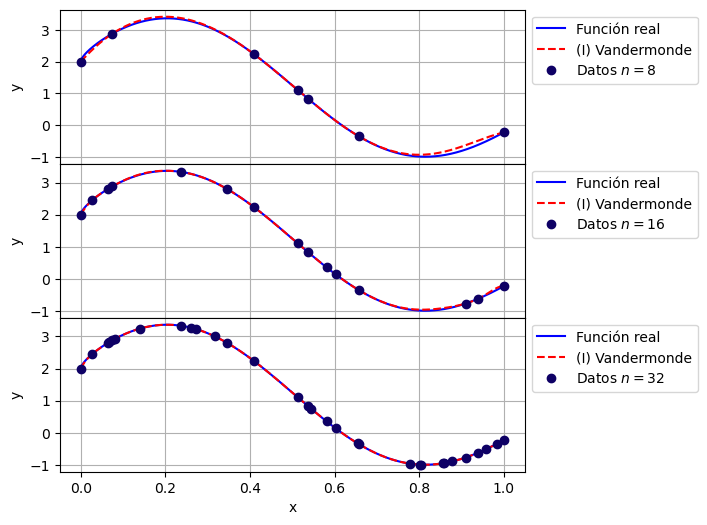

In [569]:
# (I) Polinomio de interpolación con matriz de Vandermonde con espaciamiento aleatorio para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_2, y_2, label='Función real', ls='-', c='b')
    axes[i].plot(x_2, pol_a2_v[i], label='(I) Vandermonde' , ls='--', c='r')
    axes[i].plot(x_a2[i], y_a2[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('Ivaf2.png', bbox_inches='tight')

plt.show()


#### (I) Polinomio de interpolación con Lagrange

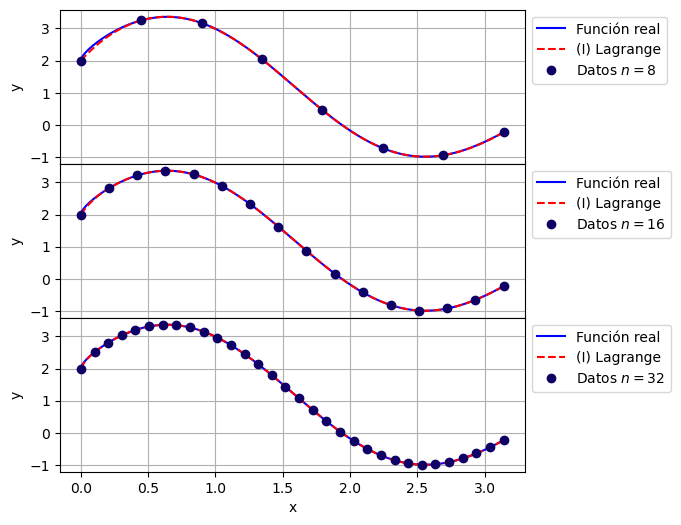

In [571]:
# (I) Polinomio de interpolación con polinomio de Lagrange con espaciamiento regular para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_1, y_1, label='Función real', ls='-', c='b')
    axes[i].plot(x_1, pol_r1_l[i], label='(I) Lagrange' , ls='--', c='r')
    axes[i].plot(x_r1[i], y_r1[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('Ilrf1.png', bbox_inches='tight')

plt.show()


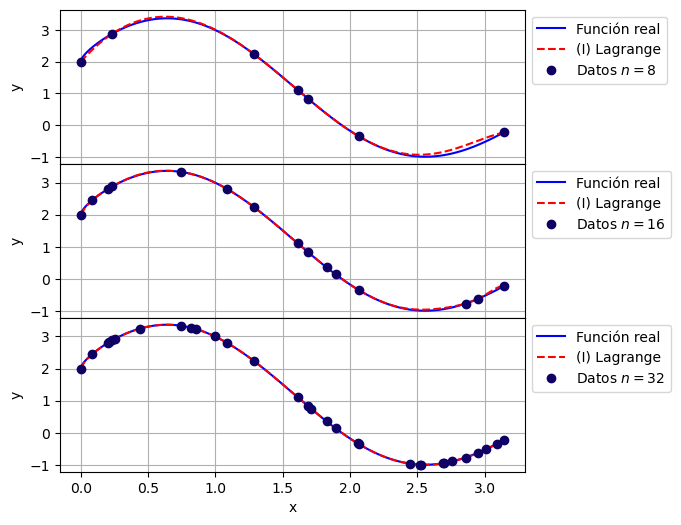

In [572]:
# (I) Polinomio de interpolación con polinomio de Lagrange con espaciamiento aleatorio para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_1, y_1, label='Función real', ls='-', c='b')
    axes[i].plot(x_1, pol_a1_l[i], label='(I) Lagrange' , ls='--', c='r')
    axes[i].plot(x_a1[i], y_a1[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('Ilaf1.png', bbox_inches='tight')

plt.show()


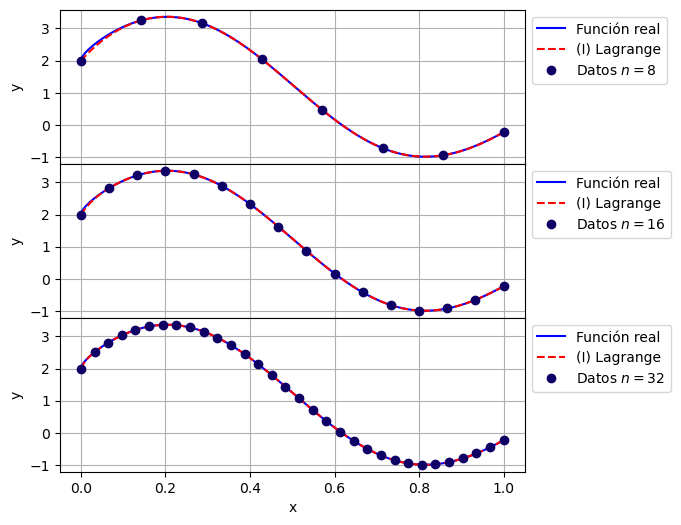

In [573]:
# (I) Polinomio de interpolación con polinomio de Lagrange con espaciamiento regular para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_2, y_2, label='Función real', ls='-', c='b')
    axes[i].plot(x_2, pol_r2_l[i], label='(I) Lagrange' , ls='--', c='r')
    axes[i].plot(x_r2[i], y_r2[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('Ilrf2.png', bbox_inches='tight')

plt.show()


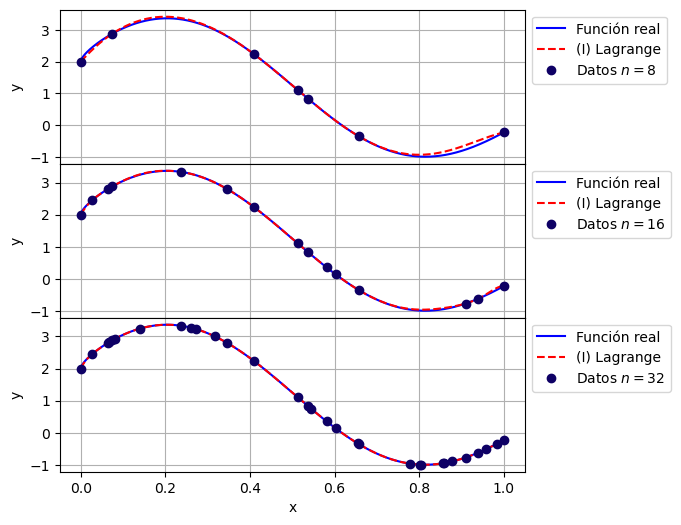

In [574]:
# (I) Polinomio de interpolación con polinomio de Lagrange con espaciamiento aleatorio para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_2, y_2, label='Función real', ls='-', c='b')
    axes[i].plot(x_2, pol_a2_l[i], label='(I) Lagrange' , ls='--', c='r')
    axes[i].plot(x_a2[i], y_a2[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('Ilaf2.png', bbox_inches='tight')

plt.show()


#### (II) Ajuste por secciones

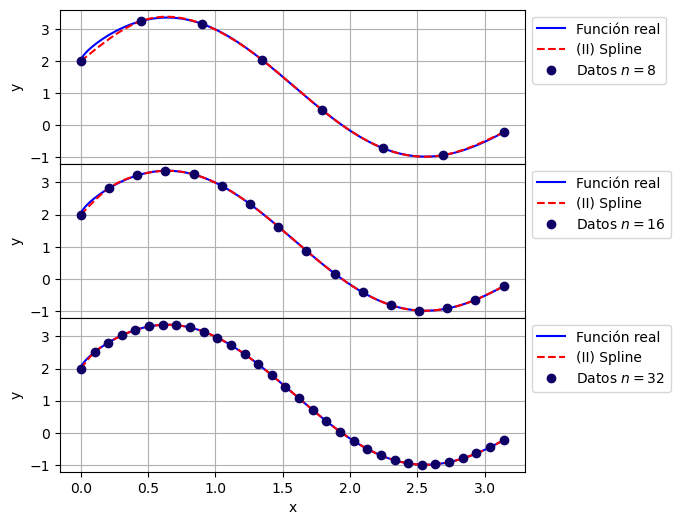

In [576]:
# (II) Ajuste por secciones con espaciamiento regular para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_1, y_1, label='Función real', ls='-', c='b')
    axes[i].plot(x_1, ajuste_cubico_r1[i], label='(II) Spline' , ls='--', c='r')
    axes[i].plot(x_r1[i], y_r1[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('IIrf1.png', bbox_inches='tight')

plt.show()


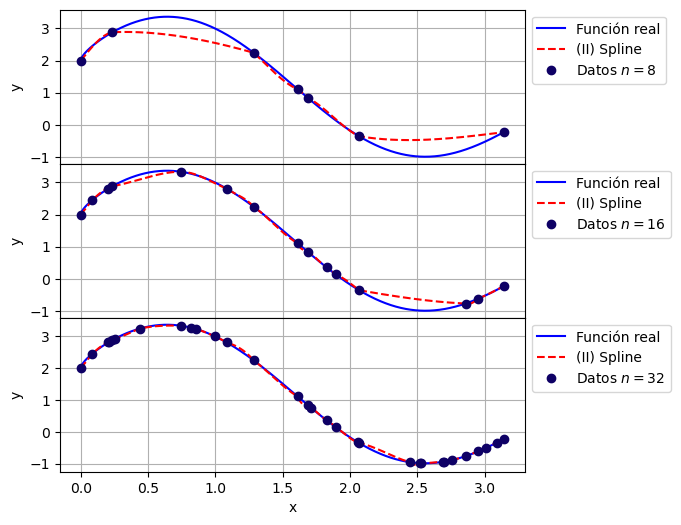

In [577]:
# (II) Ajuste por secciones con espaciamiento aleatorio para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_1, y_1, label='Función real', ls='-', c='b')
    axes[i].plot(x_1, ajuste_cubico_a1[i], label='(II) Spline' , ls='--', c='r')
    axes[i].plot(x_a1[i], y_a1[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('IIaf1.png', bbox_inches='tight')

plt.show()


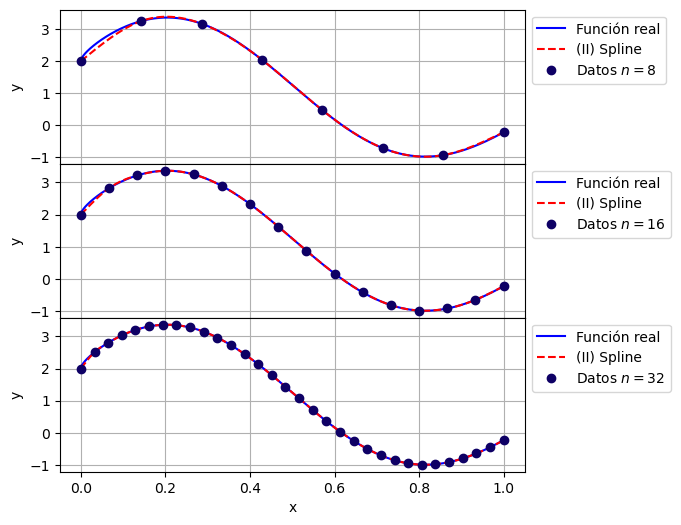

In [578]:
# (II) Ajuste por secciones con espaciamiento regular para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_2, y_2, label='Función real', ls='-', c='b')
    axes[i].plot(x_2, ajuste_cubico_r2[i], label='(II) Spline' , ls='--', c='r')
    axes[i].plot(x_r2[i], y_r2[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('IIrf2.png', bbox_inches='tight')

plt.show()


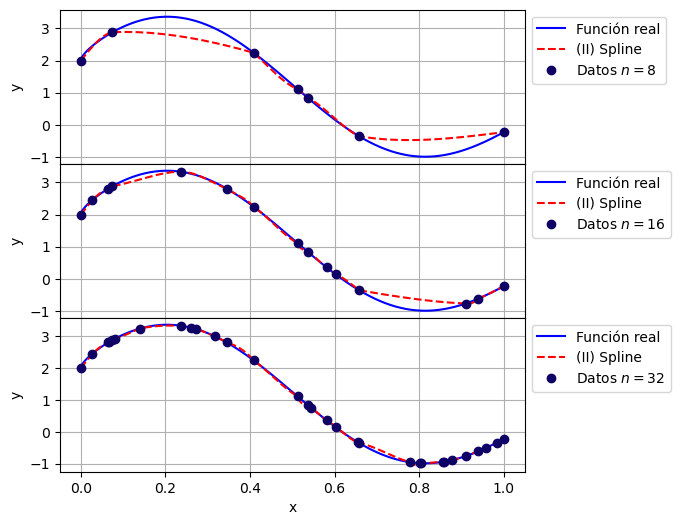

In [579]:
# (II) Ajuste por secciones con espaciamiento aleatorio para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_2, y_2, label='Función real', ls='-', c='b')
    axes[i].plot(x_2, ajuste_cubico_a2[i], label='(II) Spline' , ls='--', c='r')
    axes[i].plot(x_a2[i], y_a2[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('IIaf2.png', bbox_inches='tight')

plt.show()


#### (III) Mínimos cuadrados

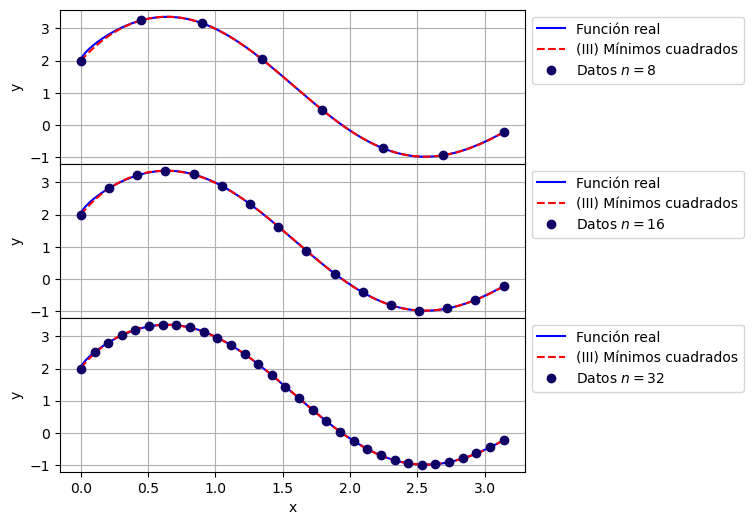

In [581]:
# (III) Mínimos cuadrados con espaciamiento regular para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_1, y_1, label='Función real', ls='-', c='b')
    axes[i].plot(x_1, min_cuad_r1[i], label='(III) Mínimos cuadrados' , ls='--', c='r')
    axes[i].plot(x_r1[i], y_r1[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('IIIrf1.png', bbox_inches='tight')

plt.show()


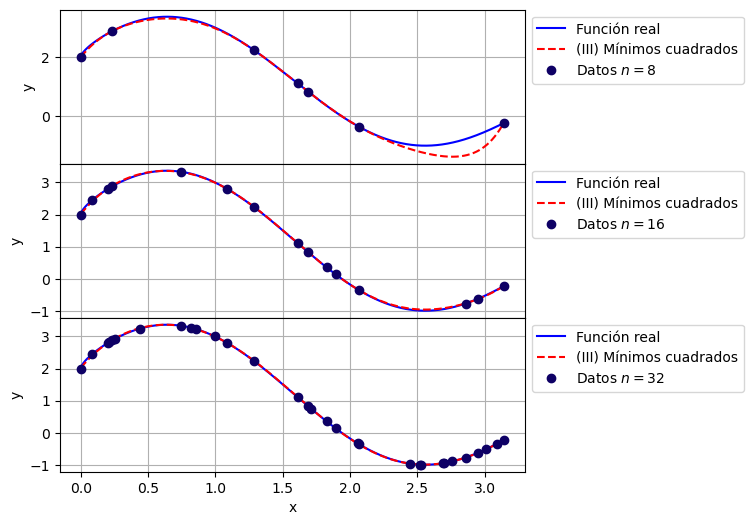

In [582]:
# (III) Mínimos cuadrados con espaciamiento aleatorio para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_1, y_1, label='Función real', ls='-', c='b')
    axes[i].plot(x_1, min_cuad_a1[i], label='(III) Mínimos cuadrados' , ls='--', c='r')
    axes[i].plot(x_a1[i], y_a1[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('IIIaf1.png', bbox_inches='tight')

plt.show()


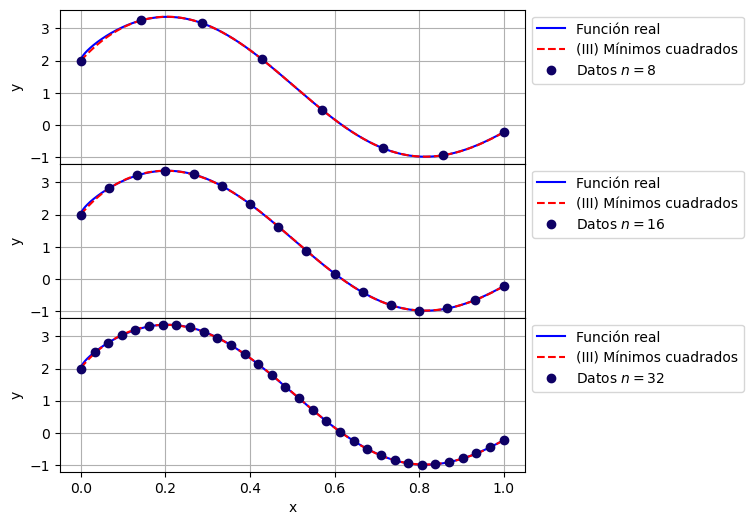

In [583]:
# (III) Mínimos cuadrados con espaciamiento regular para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_2, y_2, label='Función real', ls='-', c='b')
    axes[i].plot(x_2, min_cuad_r2[i], label='(III) Mínimos cuadrados' , ls='--', c='r')
    axes[i].plot(x_r2[i], y_r2[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('IIIrf2.png', bbox_inches='tight')

plt.show()


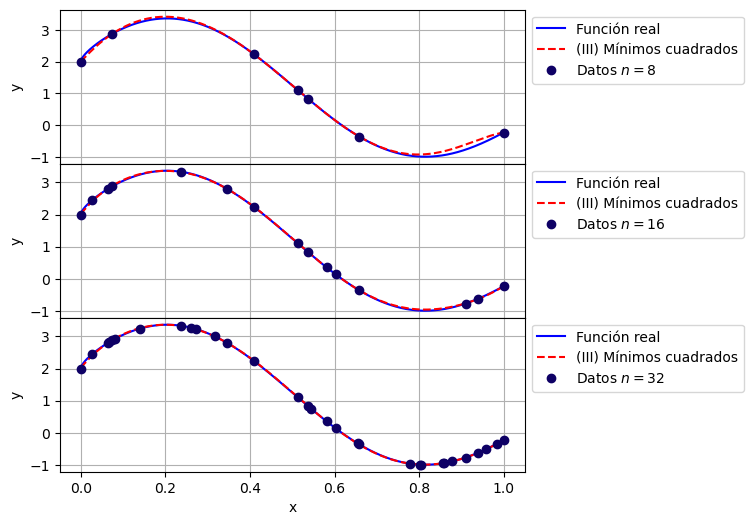

In [584]:
# (III) Mínimos cuadrados con espaciamiento aleatorio para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[i].plot(x_2, y_2, label='Función real', ls='-', c='b')
    axes[i].plot(x_2, min_cuad_a2[i], label='(III) Mínimos cuadrados' , ls='--', c='r')
    axes[i].plot(x_a2[i], y_a2[i], label=f'Datos $n={n[i]:.0f}$', ls='', marker='o', c='#0E0065')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_xlabel('x')
plt.subplots_adjust(hspace=0)

plt.savefig('IIIaf2.png', bbox_inches='tight')

plt.show()


### Error y convergencia

Para revisar el error primero realizaremos gráficas de los errores absolutos.

In [587]:
# Error absoluto del espaciamiento regular y aleatorio para f1

# (I) Polinomio de interpolación, Vandermonde
error_pol_r1_v = [np.abs(pol_r1_v[i] - y_1) for i in range(N)]
error_pol_a1_v = [np.abs(pol_a1_v[i] - y_1) for i in range(N)]

# (I) Polinomio de interpolación, Lagrange
error_pol_r1_l = [np.abs(pol_r1_l[i] - y_1) for i in range(N)]
error_pol_a1_l = [np.abs(pol_a1_l[i] - y_1) for i in range(N)]

# (II) Ajusto cúbico por secciones
error_ajuste_cubico_r1 = [np.abs(ajuste_cubico_r1[i] - y_1) for i in range(N)]
error_ajuste_cubico_a1 = [np.abs(ajuste_cubico_a1[i] - y_1) for i in range(N)]

# (III) Mínimos cuadrados
error_min_cuad_r1 = [np.abs(min_cuad_r1[i] - y_1) for i in range(N)]
error_min_cuad_a1 = [np.abs(min_cuad_a1[i] - y_1) for i in range(N)]


In [588]:
# Error absoluto del espaciamiento regular y aleatorio para f2

# (I) Polinomio de interpolación, Vandermonde
error_pol_r2_v = [np.abs(pol_r2_v[i] - y_1) for i in range(N)]
error_pol_a2_v = [np.abs(pol_a2_v[i] - y_1) for i in range(N)]

# (I) Polinomio de interpolación, Lagrange
error_pol_r2_l = [np.abs(pol_r2_l[i] - y_1) for i in range(N)]
error_pol_a2_l = [np.abs(pol_a2_l[i] - y_1) for i in range(N)]

# (II) Ajusto cúbico por secciones
error_ajuste_cubico_r2 = [np.abs(ajuste_cubico_r2[i] - y_1) for i in range(N)]
error_ajuste_cubico_a2 = [np.abs(ajuste_cubico_a2[i] - y_1) for i in range(N)]

# (III) Mínimos cuadrados
error_min_cuad_r2 = [np.abs(min_cuad_r2[i] - y_1) for i in range(N)]
error_min_cuad_a2 = [np.abs(min_cuad_a2[i] - y_1) for i in range(N)]

#### Error absoluto

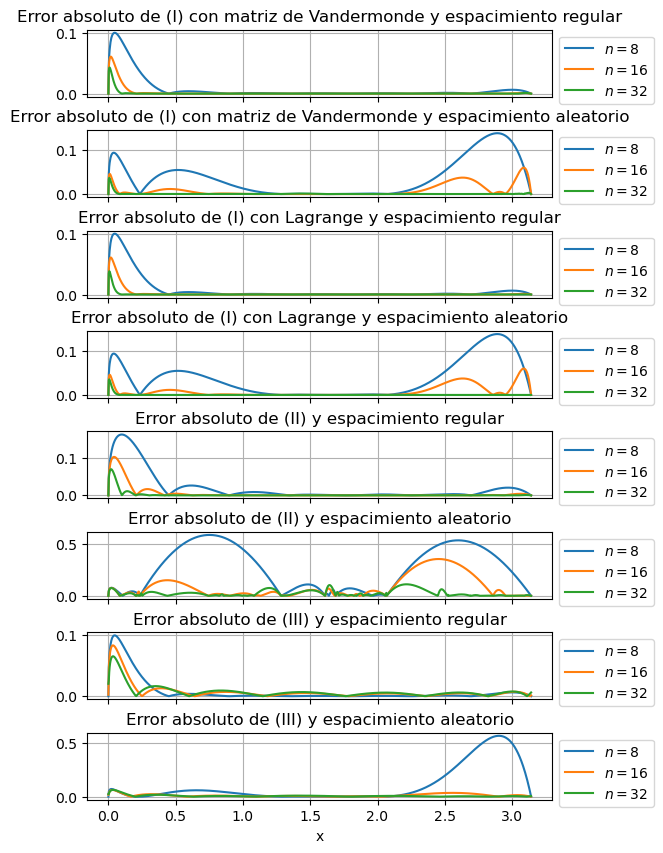

In [590]:
# Error absoluto del espaciamiento regular y aleatorio para f1

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(8, 1, figsize=(6, 10), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[0].plot(x_1, error_pol_r1_v[i], label=f'$n={n[i]:.0f}$')
    axes[1].plot(x_1, error_pol_a1_v[i], label=f'$n={n[i]:.0f}$')
    axes[2].plot(x_1, error_pol_r1_l[i], label=f'$n={n[i]:.0f}$')
    axes[3].plot(x_1, error_pol_a1_l[i], label=f'$n={n[i]:.0f}$')
    axes[4].plot(x_1, error_ajuste_cubico_r1[i], label=f'$n={n[i]:.0f}$')
    axes[5].plot(x_1, error_ajuste_cubico_a1[i], label=f'$n={n[i]:.0f}$')
    axes[6].plot(x_1, error_min_cuad_r1[i], label=f'$n={n[i]:.0f}$')
    axes[7].plot(x_1, error_min_cuad_a1[i], label=f'$n={n[i]:.0f}$')

#axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(8):
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[0].set_title('Error absoluto de (I) con matriz de Vandermonde y espacimiento regular')
axes[1].set_title('Error absoluto de (I) con matriz de Vandermonde y espacimiento aleatorio')
axes[2].set_title('Error absoluto de (I) con Lagrange y espacimiento regular')
axes[3].set_title('Error absoluto de (I) con Lagrange y espacimiento aleatorio')
axes[4].set_title('Error absoluto de (II) y espacimiento regular')
axes[5].set_title('Error absoluto de (II) y espacimiento aleatorio')
axes[6].set_title('Error absoluto de (III) y espacimiento regular')
axes[7].set_title('Error absoluto de (III) y espacimiento aleatorio')

axes[7].set_xlabel('x')
plt.subplots_adjust(hspace=0.5)

plt.savefig('interpolacion_f1.png', bbox_inches='tight')

plt.show()


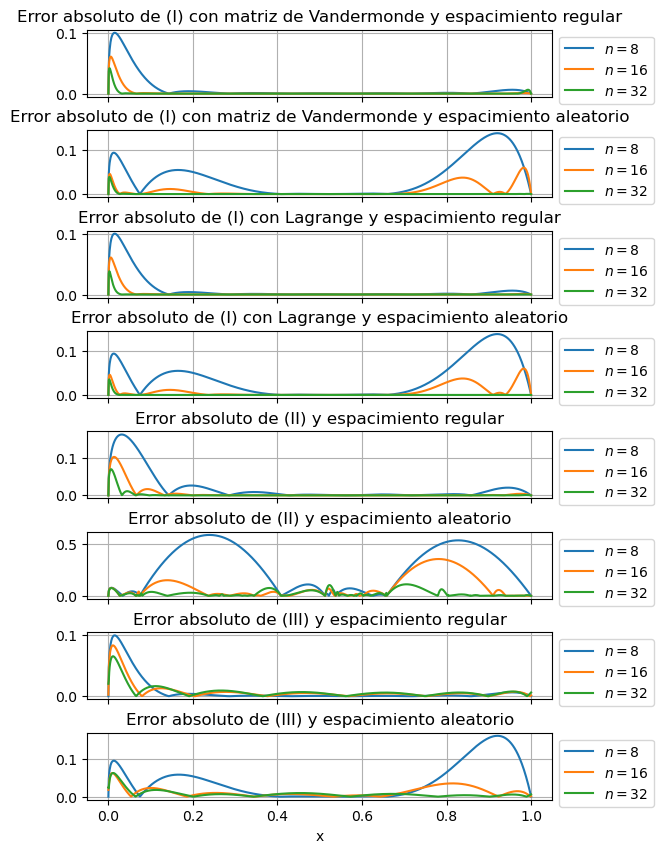

In [591]:
# Error absoluto del espaciamiento regular y aleatorio para f2

# Creamos una figura y un conjunto de subgráficas con eje horizontal compartido
fig, axes = plt.subplots(8, 1, figsize=(6, 10), sharex=True)

# Generamos las subgráficas para N = 8, 16, 32
for i in range(N):
    axes[0].plot(x_2, error_pol_r2_v[i], label=f'$n={n[i]:.0f}$')
    axes[1].plot(x_2, error_pol_a2_v[i], label=f'$n={n[i]:.0f}$')
    axes[2].plot(x_2, error_pol_r2_l[i], label=f'$n={n[i]:.0f}$')
    axes[3].plot(x_2, error_pol_a2_l[i], label=f'$n={n[i]:.0f}$')
    axes[4].plot(x_2, error_ajuste_cubico_r2[i], label=f'$n={n[i]:.0f}$')
    axes[5].plot(x_2, error_ajuste_cubico_a2[i], label=f'$n={n[i]:.0f}$')
    axes[6].plot(x_2, error_min_cuad_r2[i], label=f'$n={n[i]:.0f}$')
    axes[7].plot(x_2, error_min_cuad_a2[i], label=f'$n={n[i]:.0f}$')

#axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

for i in range(8):
    axes[i].grid(True)
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[0].set_title('Error absoluto de (I) con matriz de Vandermonde y espacimiento regular')
axes[1].set_title('Error absoluto de (I) con matriz de Vandermonde y espacimiento aleatorio')
axes[2].set_title('Error absoluto de (I) con Lagrange y espacimiento regular')
axes[3].set_title('Error absoluto de (I) con Lagrange y espacimiento aleatorio')
axes[4].set_title('Error absoluto de (II) y espacimiento regular')
axes[5].set_title('Error absoluto de (II) y espacimiento aleatorio')
axes[6].set_title('Error absoluto de (III) y espacimiento regular')
axes[7].set_title('Error absoluto de (III) y espacimiento aleatorio')

axes[7].set_xlabel('x')
plt.subplots_adjust(hspace=0.5)

plt.savefig('interpolacion_f2.png', bbox_inches='tight')

plt.show()


#### Convergencia

Para estudiar la convergencia buscaremos el máximo de los errores entre la interpolación y la función real para $1000$ puntos equidistantes en el dominio.

In [594]:
# Error máximo del espaciamiento regular y aleatorio para f1 para diferentes valores de n

# (I) Polinomio de interpolación, Vandermonde
error_max_pol_r1_vN = [np.max(error_pol_r1_v[i]) for i in range(N)]
error_max_pol_a1_vN = [np.max(error_pol_a1_v[i]) for i in range(N)]

# (I) Polinomio de interpolación, Lagrange
error_max_pol_r1_lN = [np.max(error_pol_r1_l[i]) for i in range(N)]
error_max_pol_a1_lN = [np.max(error_pol_a1_l[i]) for i in range(N)]

# (II) Ajusto cúbico por secciones
error_ajuste_cubico_r1N = [np.max(error_ajuste_cubico_r1[i]) for i in range(N)]
error_ajuste_cubico_a1N = [np.max(error_ajuste_cubico_a1[i]) for i in range(N)]

# (III) Mínimos cuadrados
error_min_cuad_r1N = [np.max(error_min_cuad_r1[i]) for i in range(N)]
error_min_cuad_a1N = [np.max(error_min_cuad_a1[i]) for i in range(N)]


In [595]:
# Error máximo del espaciamiento regular y aleatorio para f2 para diferentes valores de n

# (I) Polinomio de interpolación, Vandermonde
error_max_pol_r2_vN = [np.max(error_pol_r2_v[i]) for i in range(N)]
error_max_pol_a2_vN = [np.max(error_pol_a2_v[i]) for i in range(N)]

# (I) Polinomio de interpolación, Lagrange
error_max_pol_r2_lN = [np.max(error_pol_r2_l[i]) for i in range(N)]
error_max_pol_a2_lN = [np.max(error_pol_a2_l[i]) for i in range(N)]

# (II) Ajusto cúbico por secciones
error_ajuste_cubico_r2N = [np.max(error_ajuste_cubico_r2[i]) for i in range(N)]
error_ajuste_cubico_a2N = [np.max(error_ajuste_cubico_a2[i]) for i in range(N)]

# (III) Mínimos cuadrados
error_min_cuad_r2N = [np.max(error_min_cuad_r2[i]) for i in range(N)]
error_min_cuad_a2N = [np.max(error_min_cuad_a2[i]) for i in range(N)]


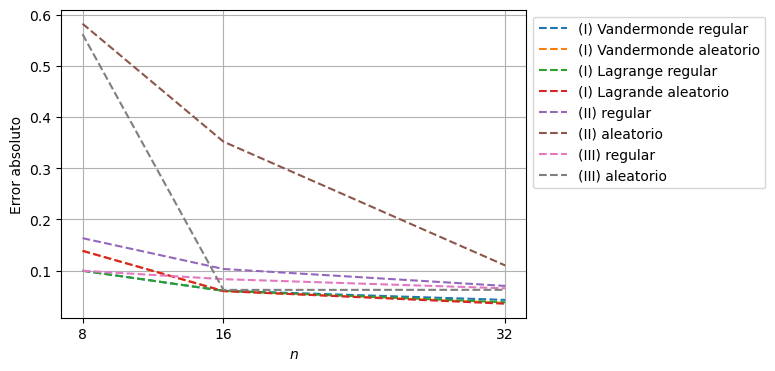

In [662]:
plt.figure(figsize=(6, 4))

plt.plot(n, error_max_pol_r1_vN, ls='--', label='(I) Vandermonde regular')
plt.plot(n, error_max_pol_a1_vN, ls='--', label='(I) Vandermonde aleatorio')
plt.plot(n, error_max_pol_r1_lN, ls='--', label='(I) Lagrange regular')
plt.plot(n, error_max_pol_a1_lN, ls='--', label='(I) Lagrande aleatorio')
plt.plot(n, error_ajuste_cubico_r1N, ls='--', label='(II) regular')
plt.plot(n, error_ajuste_cubico_a1N, ls='--', label='(II) aleatorio')
plt.plot(n, error_min_cuad_r1N, ls='--', label='(III) regular')
plt.plot(n, error_min_cuad_a1N, ls='--', label='(III) aleatorio')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xlabel('$n$')
plt.ylabel('Error absoluto')
plt.xticks(np.array([8, 16, 32]))

plt.savefig('convergencia_f1.png', bbox_inches='tight')

plt.show()


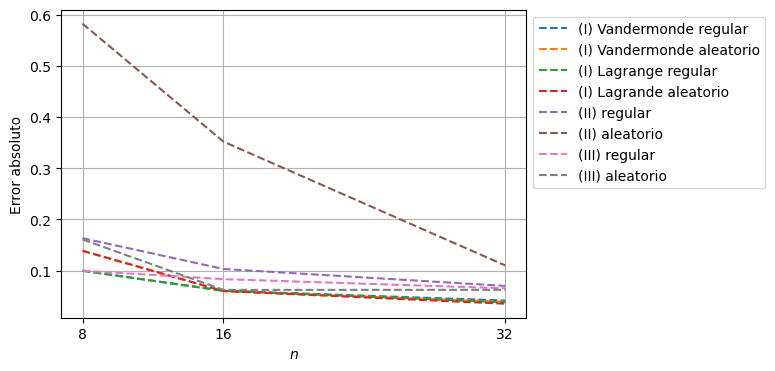

In [664]:
plt.figure(figsize=(6, 4))

plt.plot(n, error_max_pol_r2_vN, ls='--', label='(I) Vandermonde regular')
plt.plot(n, error_max_pol_a2_vN, ls='--', label='(I) Vandermonde aleatorio')
plt.plot(n, error_max_pol_r2_lN, ls='--', label='(I) Lagrange regular')
plt.plot(n, error_max_pol_a2_lN, ls='--', label='(I) Lagrande aleatorio')
plt.plot(n, error_ajuste_cubico_r2N, ls='--', label='(II) regular')
plt.plot(n, error_ajuste_cubico_a2N, ls='--', label='(II) aleatorio')
plt.plot(n, error_min_cuad_r2N, ls='--', label='(III) regular')
plt.plot(n, error_min_cuad_a2N, ls='--', label='(III) aleatorio')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xlabel('$n$')
plt.ylabel('Error absoluto')
plt.xticks(np.array([8, 16, 32]))

plt.savefig('convergencia_f2.png', bbox_inches='tight')

plt.show()


## Problema 2
**Estudiar el modelo de la cadena $XX-Z$ para diferentes números de sitios $N > 3$ y observar el comportamiento de la transición de fase cuántica calculando la magnetización $\left(m_z =\dfrac{\langle\sum_{i=1}^N\sigma_i^z\rangle}{N}\right)$ como función del cociente $g = J_x /J_z$, $g \in \mathbb{R}$. La cadena $XX-Z$ es: $$H=-J_x \sum_{i=1}^{N-1}\sigma_i^x \sigma_{i+1}^x-J_x \sigma_0^x \sigma_N^x-J_z \sum_i \sigma_i^z\quad.$$**

**Nota 1: Elegir una escala relevante para hacer las gráficas como función de “$g$” y “$1/g$”.**

**Nota 2: Comentar sobre el comportamiento conforme aumenta el número de sitios $N$.**

**Nota 3:Investigar sobre la solución exacta de este modelo y comparar los resultados de sus simulaciones con la literatura.**

In [40]:
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt


### Construcción del Hamiltoniano y el operador de magnetización

Podemos definir $g=J_{x}/J_{z}$ y tomando $J_{z}=1$ (lo que es equivalente a factorizar $J_{z}$ del Hamiltoniano) tendremos
\begin{equation}
H^{\prime} = -g \sum_{i=1}^{N-1}\sigma_i^x \sigma_{i+1}^x - g \sigma_0^x \sigma_N^x - \sum_i \sigma_i^z\quad.
\end{equation}

In [42]:
# Definimos las matrices de Pauli
σx = np.array([[0, 1], [1, 0]], dtype=complex)
σz = np.array([[1, 0], [0, -1]], dtype=complex)


In [44]:
def hamiltoniano_xxz(N, g):
    """
    Genera la representación matricial del Hamiltoniano de la cadena XX-Z 
    para N sitios y parámetro de interacción g = J_x/J_z.
    """
    
    H = 0
    
    for i in range(N):
        σx_i = 1
        σz_i = 1
        σx_ip1 = 1
        σz_ip1 = 1
        
        # Construcción de operadores para los sitios i e i+1 (con condiciones periódicas a la frontera)
        for j in range(N):

            # Construcción de la representación matricial de σx_i y σz_i
            if j == i:
                σx_i = kron(σx_i, σx)
                σz_i = kron(σz_i, σz)
                
            else:
                σx_i = kron(σx_i, identity(2))
                σz_i = kron(σz_i, identity(2))

            # Construcción de la representación matricial de σx_{i+1} con condiciones periódicas a la frontera
            if j == (i + 1) % N: # Condición periódica a la frontera
                σx_ip1 = kron(σx_ip1, σx)
                
            else:
                σx_ip1 = kron(σx_ip1, identity(2))

        # Construcción del Hamiltoniano
        H += g * σx_i.dot(σx_ip1)
        H += σz_i

    return - H


In [46]:
def magnetizacion(N):
    """
    Genera la representación matricial del operador de magnetización para
    N sitios.
    """
    
    Mz = 0
    
    for i in range(N):
        σz_i = 1
        
        for j in range(N):

            # Construcción de la representación matricial de σx_i
            if j == i:
                σz_i = kron(σz_i, σz)
                
            else:
                σz_i = kron(σz_i, identity(2))

        # Construcción del operador                
        Mz += σz_i
        
    return Mz


In [48]:
def datos_XXZ(N, g_puntos):
    """
    Genera los datos de la magnetización para el estado base del Hamiltoniano
    de la cadena XX-Z para N sitios.
    """
    
    n = len(g_puntos)
    Mz = magnetizacion(N)
    mz = []
    
    for i in range(n):
        H = hamiltoniano_xxz(N, g_puntos[i])
        eigenvalor, eigenvector = eigsh(H, k=1, which='SA')
        estado_base = eigenvector[:, 0]
        mz_i = estado_base.conj().T @ Mz @ estado_base
        mz.append(mz_i/N)
        
    return np.real(mz)


### Implementación

In [50]:
g = np.logspace(-2, 2., 1000)
N = [n for n in range(3, 9)]
mz = [datos_XXZ(n, g) for n in N]


### Figuras

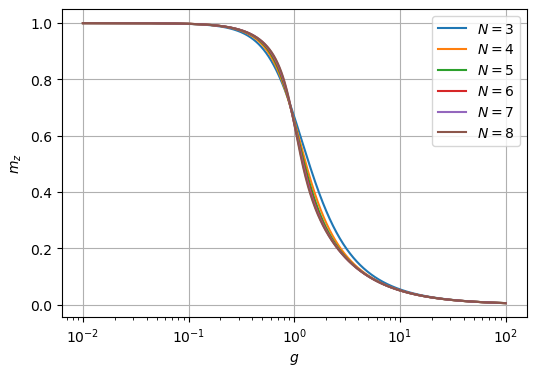

In [54]:
plt.figure(figsize=(6, 4))

for i in range(len(N)):
    plt.semilogx(g, mz[i], ls='-', label=f'$N={N[i]:.0f}$')
    
plt.xlabel("$g$")
plt.ylabel("$m_z$")
plt.legend()
plt.grid(True)

plt.savefig('magnetizacion.png', format='png', dpi=300)

plt.show()


## Problema 3
**Estudiar el modelo de Bose-Hubbard en una dimensión con condiciones periódicas para diferentes números de sitios N > 3, calcular las fluctuaciones por sitio como función de $g = t /U.$**

**Nota 1: Elegir una escala relevante para hacer las gráficas como función de “$g$” y “$1/g$”.**

**Nota 2: Comentar sobre el comportamiento conforme aumenta el número de sitios $N$.**

**Nota 3:Investigar sobre la solución numérica de este modelo en 1D y comparar los resultados de sus simulaciones con la literatura.**


In [1]:
import numpy as np
from scipy.sparse import dok_matrix, diags
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt


El Hamiltoniano de Bose-Hubbard es
\begin{equation}
\hat{H}=-t\sum_{i}\hat{b}^{\dagger}_{i}\hat{b}_{i+1}+\dfrac{U}{2}\sum_{i}\hat{n}_i({\hat{n}_i-1})
\end{equation}
Podemos definir $g=t/U$ y tomando $U=1$ (lo que es equivalente a factorizar $U$ del Hamiltoniano) tendremos
\begin{equation}
\hat{H}^{\prime}=-g\sum_{i}\hat{b}^{\dagger}_{i}\hat{b}_{i+1}+\dfrac{1}{2}\sum_{i}\hat{n}_i({\hat{n}_i-1})
\end{equation}


$N$ es el número de sitios y $M$ es el número total de bosones que tenemos.

### Enumeración de estados

In [3]:
def factorial(n):
    
    a = 1
    
    for i in range(1, n+1):
        a *= i
        
    return a
    

In [5]:
def dim_hilbert(N, M):

    return int(factorial(N + M - 1)/(factorial(N)*factorial(M-1)))


In [7]:
def orden_lexicografico(N, M):
    """
    Genera un conjunto de arreglos de M entradas para los que la suma de las 
    entradas sea N. Esta base estará ordenada de manera lexicográfica.
    """

    # Estado maximal
    arr = np.zeros(M, dtype = int)
    arr[0] = N
    
    i = 0
    base = []
    
    while arr[-1] != N:
        k = i % M - 1
        arr_tmp = np.zeros(M, dtype=int)
        
        if (arr[k] != 0) and (np.sum(arr[k + 1 : M - 1]) == 0):
            arr_tmp[:k] = arr[:k]
            arr_tmp[k] = arr[k] - 1
            arr_tmp[k + 1] = N - np.sum(arr_tmp[:k + 1])
            base.append(arr.copy())
            arr = arr_tmp
            
        i += 1
        
    base.append(arr.copy())
    
    return base            
        

In [9]:
def etiqueta(estado, M):
    """
    Genera etiquetas diferentes para la base lexicográfica.
    """
    
    t = 0
    
    for i in range(M):
        t += np.sqrt(100 * i + 103) * estado[i]

    return t


### Construcción del Hamiltoniano y los operadores de fluctuación por sitio

In [76]:
def construccion_n_i_op(i, base):
    """
    Genera la representación matricial del operador de número para el 
    sitio i en la base base.
    """
    
    n_diag_principal = [estado[i] for d, estado in enumerate(base)]
    n_i_op = diags(n_diag_principal, offsets=0, format='csr')
    
    return n_i_op


In [78]:
def fluctuacion_i(i, base, estado_base):
    """
    Calcula la fluctuación (desviación estándar) del operador de número
    para el sitio i en la base base con respecto al estado base estado_base.
    """
    
    n_i_op = construccion_n_i_op(i, base)
    estado_base_co = estado_base.conj().T
    n_i_val = estado_base_co @ n_i_op @ estado_base
    n_i_val_cuad = estado_base_co @ n_i_op @ n_i_op @ estado_base
    fluc_i = np.sqrt(n_i_val_cuad - n_i_val**2)
    
    return fluc_i
    

In [48]:
def fluctuaciones_BH(N, M, g):
    """
    Calcula las fluctuaciones del operador de número para los M sitios con 
    respecto al estado base del modelo de Bose--Hubbard de N bosones, M sitios
    y parámetro de interacción g = t/U.
    """
    
    base = orden_lexicografico(N, M) # Base lexicográfica
    T = [etiqueta(estado, M) for estado in base] # Etiquetas de la base lexicográfica
    TSorted = np.sort(T) # Base lexicográfica ordenada de forma ascendente
    dicc_TSorted = {TSorted[i]:T.index(TSorted[i]) for i in range(len(TSorted))} # Diccionario de base lexicográfica ordenada de forma ascendente junto con su respectivo índice en la base del principio
    D = len(base) # Dimensión del espacio de Hilbert del modelo de Bose--Hubbard
    H = dok_matrix((D, D), dtype=np.float64)
    
    # Construcción del Hamiltoniano
    for d, estado in enumerate(base):
        
        for i in range(M):
            n_i = estado[i]
            H[d, d] += n_i * (n_i - 1) / 2 # Elementos de H en la diagonal, corresponden a la parte de interacción del Hamiltoniano
            
            if n_i > 0:
                
                for j in range(M):
                    
                    if np.abs(i-j) == 1 or (i == 0 and j == M - 1) or (j == 0 and i == M - 1): # Esta condición es para primeros vecinos y con condiciones periódicas sobre los operadores de creación y aniquilación en la parte cinética del Hamiltoniano
                        estado_nuevo = estado.copy()
                        estado_nuevo[i] -= 1 # Operador de aniquilación sobre el estado
                        estado_nuevo[j] += 1 # Operador de creación sobre el estado
                        t = etiqueta(estado_nuevo, M) # Obtenemos la etiqueta de este estado

                        # Localizamos el nuevo estado en la base lexicográfica ordenada de forma ascendente
                        if t in TSorted: 
                            k = dicc_TSorted[t] # Localizamos el nuevo estado en la base del principio
                            H[d, k] -= g * np.sqrt(estado_nuevo[j] * (estado_nuevo[i] + 1)) # Elementos de H fuera de la diagonal

    energia_base, estado_base = eigsh(H, k=1, which='SA')  # Eigenenergía y eigenvector del estado base

    flucs = [fluctuacion_i(i, base, estado_base)[0][0] for i in range(M)] # Calculamos las fluctuaciones del operador de número con respecto al estado base
        
    return flucs


In [50]:
def datos_g_fluctuaciones(N, M, g_puntos):
    """
    Genera los datos de las fluctuaciones para el estado base del modelo
    de Bose--Hubbard de N bosones y M sitios con el arreglo de parámetro
    de interacción g_puntos.
    """
    
    n = len(g_puntos)
    fluc_puntos = np.zeros([M ,n])
    
    for i in range(n):
        flucs = fluctuaciones_BH(N, M, g_puntos[i])
        
        for k in range(M):
            fluc_puntos[k, i] = flucs[k]

    return fluc_puntos


### Implementación

In [128]:
N_arr = [i for i in range(3, 9)] # Tardó ~50 min
n = len(N_arr)
inv_g_arr = np.linspace(0.01, 20., 500)
g_arr = inv_g_arr**-1

fluc_arr = []
for i in range(n):
    fluc = datos_g_fluctuaciones(N_arr[i], N_arr[i], g_arr)
    fluc_arr.append(fluc)
    

### Figuras

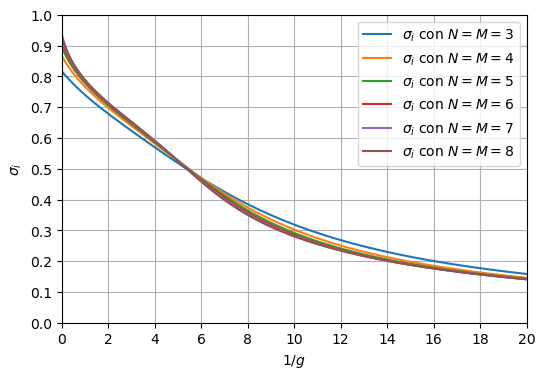

In [656]:
plt.figure(figsize=(6, 4))

for i in range(n):
        plt.plot(inv_g_arr, fluc_arr[i][0], ls='-', label=f'$\sigma_i$ con $N=M={N_arr[i]}$')

plt.xlabel("$1/g$")
plt.ylabel("$\sigma_{i}$")
plt.legend()
plt.grid(True)
plt.xlim(0, 20)  # Límites en x
plt.ylim(0, 1)  # Límites en y
plt.xticks(np.arange(0, 22, 2))  # Red cada 2.0 en x
plt.yticks(np.arange(0, 1.1, 0.1))  # Red cada 0.1 en y

plt.savefig('fluctuaciones.png', format='png', dpi=300)

plt.show()


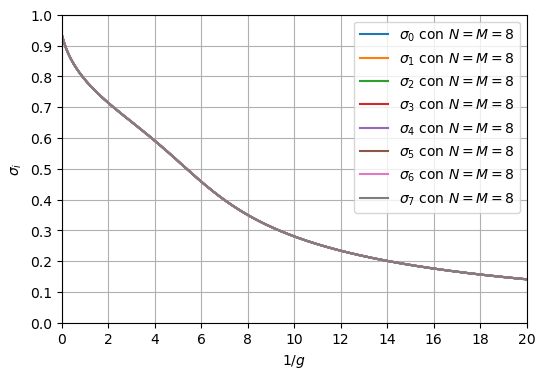

In [650]:
plt.figure(figsize=(6, 4))

for i in range(N_arr[5]):
    plt.plot(inv_g_arr, fluc_arr[5][i], ls='-', label=f'$\sigma_{i}$ con $N=M=8$')

plt.xlabel("$1/g$")
plt.ylabel("$\sigma_{i}$")
plt.legend()
plt.grid(True)
plt.xlim(0, 20)  # Límites en x
plt.ylim(0, 1)  # Límites en y
plt.xticks(np.arange(0, 22, 2))  # Red cada 2.0 en x
plt.yticks(np.arange(0, 1.1, 0.1))  # Red cada 0.1 en y

plt.savefig('fluctuaciones8.png', format='png', dpi=300)

plt.show()
